In [0]:
! pip install albumentations

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor #convert from numpy to tensor - augmentation also
%matplotlib inline
from albumentations import (
    Compose, OneOf, Rotate, Flip, Blur, ToGray,GaussNoise, MedianBlur, 
   InvertImg, RandomBrightness, RandomContrast, Transpose, ChannelShuffle, HorizontalFlip, VerticalFlip,
    IAAAdditiveGaussianNoise,RandomRotate90, MotionBlur, ShiftScaleRotate, IAASharpen,
    RandomBrightnessContrast, CLAHE, HueSaturationValue ,OpticalDistortion,GridDistortion,IAAPiecewiseAffine, IAAEmboss
)

In [0]:
trainset = torchvision.datasets.MNIST(root = '', train = True, download=True);
num_classes = len(trainset.classes)
idx = np.random.randint(trainset.data.shape[0])

def load_data_and_plot(xtrain ,ytrain):
  lst_of_numbers = {}
  i = 0
  for label,img in zip(ytrain, xtrain):
    if label not in lst_of_numbers.keys():
      lst_of_numbers[label] = []
    lst_of_numbers[label] += [img]
  return lst_of_numbers

all_data = load_data_and_plot(trainset.data.numpy() ,trainset.targets.numpy())

def create_numbers_from_data(data):
  new_db = {}
  for number in range (0,101):
    new_db[number] = []
    for _ in range (0,10):
      new_image = np.zeros((28,84), dtype= 'uint8') #size of new image
      unity = number % 10
      dozens = number // 10
      if number > 99:
        dozens = dozens % 10 
      hundreds = number // 100
      unity_img_lst = data[unity] #list of images of a number
      dozens_img_lst = data[dozens]
      hundreds_img_lst = data[hundreds] 
      which_unity_image = np.random.randint(0,len(unity_img_lst)) 
      which_dozens_image = np.random.randint(0,len(dozens_img_lst)) 
      which_hundreds_image = np.random.randint(0,len(hundreds_img_lst)) 
      unity_img = data[unity][which_unity_image] #unity of a number
      dozens_img = data[dozens][which_dozens_image] #dozen of a number
      hundreds_img = data[hundreds][which_hundreds_image] #hundreds of a number
      new_image[ :28, 56:84] = unity_img
      new_image[ :28, 28:56] = dozens_img
      new_image[ :28, :28] = hundreds_img
      new_db[number] += [new_image]
  return new_db

new_data = create_numbers_from_data(all_data)

def prepare_data(data):
    targets = [] 
    new_data = []
    for label,images in data.items():
        new_data += data[label]
        for img in images:
            targets += [label]
    return targets,new_data

targets, data = prepare_data(new_data)

In [0]:
def make_augmantations(p = 1):
     return Compose([
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45,border_mode=cv2.BORDER_REPLICATE, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            IAASharpen(),
            IAAEmboss(),
        ], p=0.3),
    ], p=p)


In [0]:
class MNISTDataset(Dataset):
    def __init__(self, data, targets, transforms = None):
        super(MNISTDataset, self).__init__()
        self.x_train = data
        self.y_train = targets
        self.transform = transforms

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        if self.transform:
            x = self.transform(image = x)
            x = x['image']
        return x, y
    
    def __len__(self):
        return len(self.x_train)

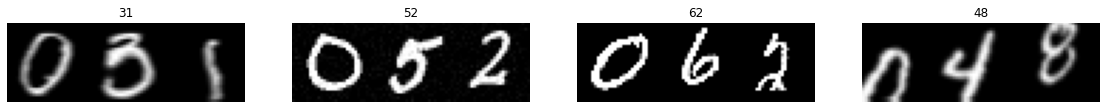

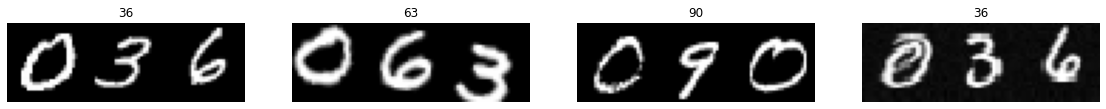

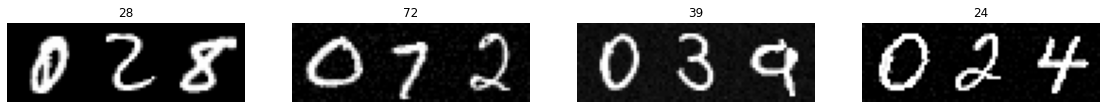

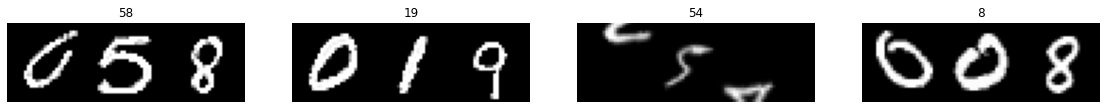

In [58]:
mnist_transforms = make_augmantations()
mnist_dataset = MNISTDataset(data,targets, transforms=mnist_transforms)
BS = 4
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BS , shuffle=True, num_workers=2)

def plot_batch(images, targets):
    plt.figure(figsize=[40, 40])
    for i,img in enumerate(images):
        plt.subplot(1, 8, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(targets[i].numpy())
    plt.show()

def plot_images_after_aug():
    next_batch = iter(mnist_dataloader)
    for i in range(4):
        images, labeles = next(next_batch)
        plot_batch(images, labeles)

plot_images_after_aug()

In [0]:
!pip install imageio
!pip install kaggle

In [0]:
import os
import glob
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [0]:
#changing the working directory
%cd /content/gdrive/My Drive/kaggle

In [0]:
images_folder = glob.glob('/content/gdrive/My Drive/kaggle/cityscapes_data/train/*.jpg')             

In [0]:
def load_images_from_train(images_path):
    img_lst = []
    seg_lst = []
    for img in images_folder:
        new_img = np.copy(plt.imread(img)[0:250, 0:255]).astype('uint8')
        new_seg_img = np.copy(plt.imread(img)[0:250, 256:500]).astype('uint8')
        np.array(img_lst.append(new_img))  
        np.array(seg_lst.append(new_seg_img))
    return img_lst, seg_lst

images ,segs = load_images_from_train(images_folder)

In [0]:
class KaggleDataset(Dataset):
    def __init__(self, images, segs, transforms = None):
        super(KaggleDataset, self).__init__()
        self.images = images
        self.segs = segs
        self.transform = transforms

    def __getitem__(self, idx):
        image = self.images[idx]
        seg = self.segs[idx]
        if self.transform:
            after = self.transform(image = image , mask = seg)
            image = after['image']
            seg = after['mask']
        return torch.from_numpy(image), torch.from_numpy(seg)

    
    def __len__(self):
        return len(self.images)

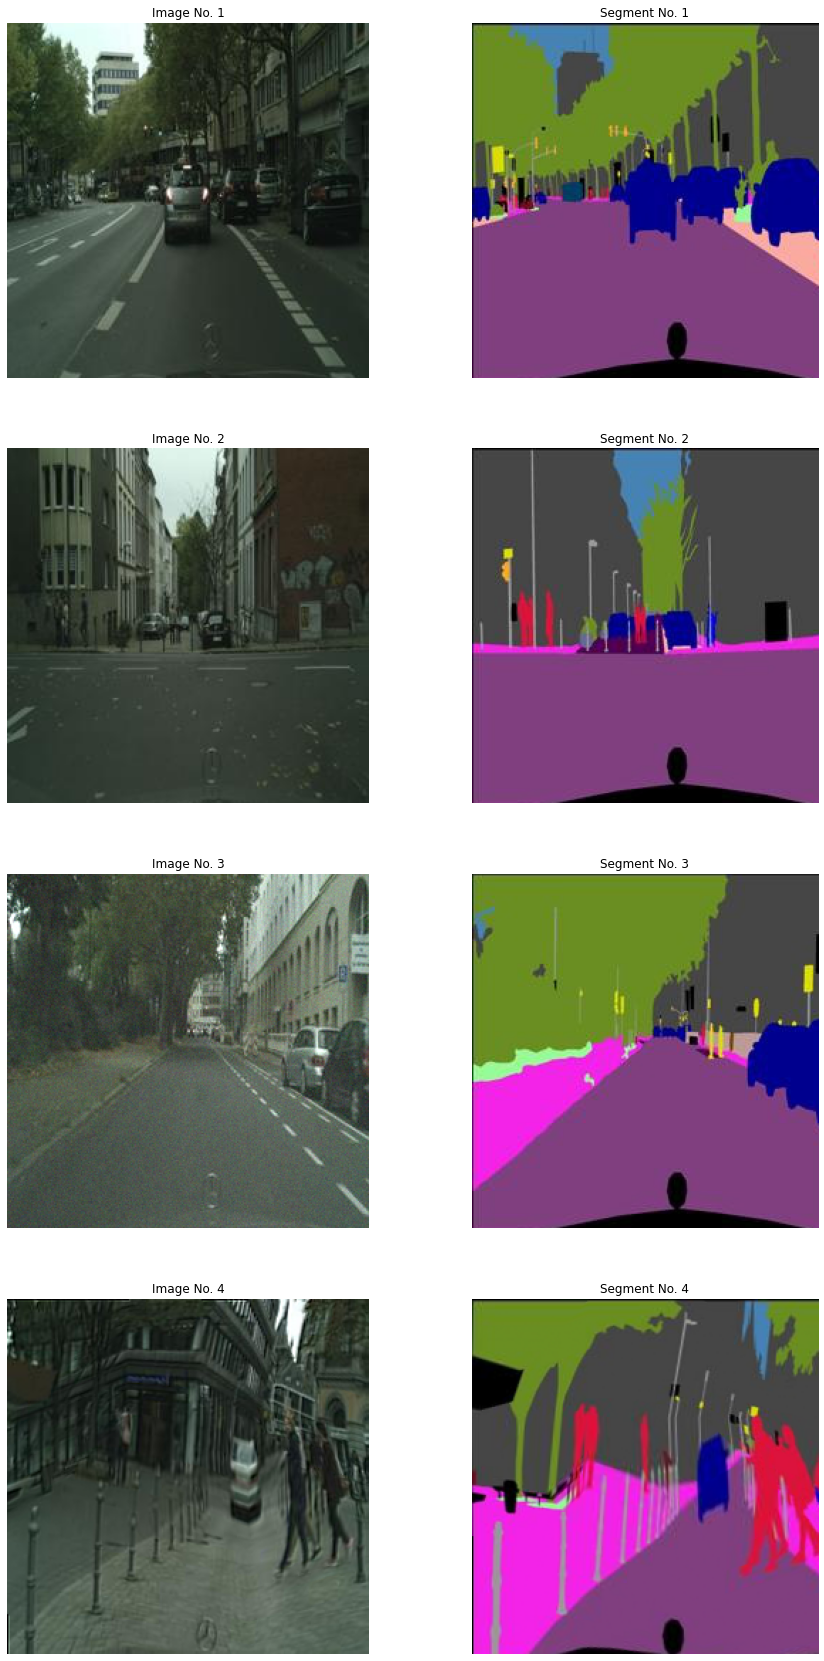

In [69]:
kaggle_transforms = make_augmantations()
kaggle_dataset = KaggleDataset(images ,segs, transforms=kaggle_transforms)
BS = 4
kaggle_dataloader = DataLoader(kaggle_dataset, batch_size=BS , shuffle=True, num_workers=2)

def plot_batch():
    next_batch = iter(kaggle_dataloader)
    images, segs = next(next_batch)
    plt.figure(figsize=[15, 30])
    ctr = 0
    for idx,(img,seg) in enumerate(zip(images,segs)):
        plt.subplot(len(images), 2, ctr + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image No. {idx+1}")
        plt.axis('off')
        plt.subplot(len(images), 2, ctr + 2)
        plt.imshow(seg, cmap='gray')
        plt.title(f"Segment No. {idx+1}")
        plt.axis('off')
        ctr +=2
    plt.show()

plot_batch()